In [21]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

#print(os.listdir("../input"))
print(os.listdir('/kaggle/input/'))

['skin-cancer-mnist-ham10000']


In [22]:
print(torch.cuda.is_available()) # Check GPU

True


In [23]:
data_dir = '../input/skin-cancer-mnist-ham10000'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [24]:
# Values stored to save future run time
norm_mean = [0.7630392, 0.5456477, 0.57004845]
norm_std = [0.1409286, 0.15261266, 0.16997074]

In [25]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [26]:
# Determine how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [27]:
# Identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# Apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated


In [28]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [29]:
# Filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [30]:
# Create a val set using df as none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [31]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [32]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filter out training rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [33]:
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
dermatofibroma                    1067
Benign keratosis-like lesions     1011
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: cell_type, dtype: int64

In [34]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [35]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [36]:
# Split the test set again in a validation set and a true test set:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [37]:
print(len(df_test))
df_test['cell_type'].value_counts()

552


Melanocytic nevi                  444
Benign keratosis-like lesions      47
dermatofibroma                     20
Basal cell carcinoma               15
Actinic keratoses                  12
Vascular lesions                    8
Dermatofibroma                      6
Name: cell_type, dtype: int64

# Set model

In [38]:
# feature_extract is a boolean that defines finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [39]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "mobilenet":
        model_ft = models.mobilenet_v2(pretrained=True, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [40]:
print(torch.cuda.is_available())

True


In [41]:

model_name = "mobilenet"
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Using device: cuda')
else:
    print("Using device: cpu")
#device = torch.device('cuda:0')
# device = torch.device('cpu')
# Put the model on the device:
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Using device: cuda


# Data augmentation

In [42]:

# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [43]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [44]:
# Define the training set using the table train_df and using the defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Same for the test set:
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [45]:
# Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [46]:
# This function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [47]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [48]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [49]:
epoch_num = 10 
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1124], [train loss 1.60074], [train acc 0.53625]
[epoch 1], [iter 200 / 1124], [train loss 1.29332], [train acc 0.58437]
[epoch 1], [iter 300 / 1124], [train loss 1.13369], [train acc 0.62469]
[epoch 1], [iter 400 / 1124], [train loss 1.04922], [train acc 0.64445]
[epoch 1], [iter 500 / 1124], [train loss 0.98688], [train acc 0.66187]
[epoch 1], [iter 600 / 1124], [train loss 0.94266], [train acc 0.67250]
[epoch 1], [iter 700 / 1124], [train loss 0.91063], [train acc 0.68147]
[epoch 1], [iter 800 / 1124], [train loss 0.87521], [train acc 0.69277]
[epoch 1], [iter 900 / 1124], [train loss 0.85010], [train acc 0.70021]
[epoch 1], [iter 1000 / 1124], [train loss 0.82821], [train acc 0.70656]
[epoch 1], [iter 1100 / 1124], [train loss 0.80794], [train acc 0.71330]



0it [00:00, ?it/s]
1it [00:02,  2.20s/it]
3it [00:02,  1.64it/s]
5it [00:04,  1.36it/s]
7it [00:04,  2.25it/s]
9it [00:05,  1.71it/s]
11it [00:05,  2.51it/s]
13it [00:07,  1.94it/s]
18it [00:08,  2.16it/s]
 10%|█         | 1/10 [08:27<1:16:05, 507.29s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.47767], [val acc 0.84722]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.47767], [val acc 0.84722]
*****************************************************
[epoch 2], [iter 100 / 1124], [train loss 0.58936], [train acc 0.77875]
[epoch 2], [iter 200 / 1124], [train loss 0.57259], [train acc 0.78766]
[epoch 2], [iter 300 / 1124], [train loss 0.56751], [train acc 0.78792]
[epoch 2], [iter 400 / 1124], [train loss 0.54822], [train acc 0.79633]
[epoch 2], [iter 500 / 1124], [train loss 0.54623], [train acc 0.79431]
[epoch 2], [iter 600 / 1124], [train loss 0.54084], [train acc 0.79615]
[epoch 2], [iter 700 / 1124], [train loss 0.53931], [train acc 0.79580]
[epoch 2], [iter 800 / 1124], [train loss 0.53445], [train acc 0.79859]
[epoch 2], [iter 900 / 1124], [train loss 0.53020], [train acc 0.79934]
[epoch 2], 


0it [00:00, ?it/s]
1it [00:01,  1.65s/it]
3it [00:01,  2.06it/s]
5it [00:03,  1.69it/s]
6it [00:03,  2.17it/s]
8it [00:03,  3.46it/s]
9it [00:04,  1.77it/s]
10it [00:05,  2.14it/s]
11it [00:05,  2.68it/s]
13it [00:06,  1.88it/s]
14it [00:06,  2.32it/s]
18it [00:07,  2.43it/s]
 20%|██        | 2/10 [16:48<1:07:08, 503.51s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.51191], [val acc 0.81151]
------------------------------------------------------------
[epoch 3], [iter 100 / 1124], [train loss 0.48218], [train acc 0.81750]
[epoch 3], [iter 200 / 1124], [train loss 0.47804], [train acc 0.81734]
[epoch 3], [iter 300 / 1124], [train loss 0.46830], [train acc 0.82219]
[epoch 3], [iter 400 / 1124], [train loss 0.46710], [train acc 0.82086]
[epoch 3], [iter 500 / 1124], [train loss 0.47007], [train acc 0.82331]
[epoch 3], [iter 600 / 1124], [train loss 0.46833], [train acc 0.82323]
[epoch 3], [iter 700 / 1124], [train loss 0.46856], [train acc 0.82321]
[epoch 3], [iter 800 / 1124], [train loss 0.46517], [train acc 0.82418]
[epoch 3], [iter 900 / 1124], [train loss 0.46322], [train acc 0.82465]
[epoch 3], [iter 1000 / 1124], [train loss 0.46278], [train acc 0.82463]
[epoch 3], [iter 1100 / 1124], [train loss 0.45878], [train acc 0.82673]



0it [00:00, ?it/s]
1it [00:01,  1.57s/it]
2it [00:01,  1.39it/s]
4it [00:01,  3.23it/s]
5it [00:03,  1.58it/s]
6it [00:03,  2.12it/s]
7it [00:03,  2.79it/s]
9it [00:04,  1.89it/s]
10it [00:04,  2.37it/s]
12it [00:05,  3.68it/s]
14it [00:06,  2.37it/s]
18it [00:07,  2.55it/s]
 30%|███       | 3/10 [25:09<58:36, 502.32s/it]  

------------------------------------------------------------
[epoch 3], [val loss 0.33164], [val acc 0.88542]
------------------------------------------------------------
*****************************************************
best record: [epoch 3], [val loss 0.33164], [val acc 0.88542]
*****************************************************
[epoch 4], [iter 100 / 1124], [train loss 0.41579], [train acc 0.84313]
[epoch 4], [iter 200 / 1124], [train loss 0.40485], [train acc 0.84266]
[epoch 4], [iter 300 / 1124], [train loss 0.40684], [train acc 0.84406]
[epoch 4], [iter 400 / 1124], [train loss 0.40357], [train acc 0.84570]
[epoch 4], [iter 500 / 1124], [train loss 0.40409], [train acc 0.84700]
[epoch 4], [iter 600 / 1124], [train loss 0.40351], [train acc 0.84719]
[epoch 4], [iter 700 / 1124], [train loss 0.40560], [train acc 0.84661]
[epoch 4], [iter 800 / 1124], [train loss 0.40731], [train acc 0.84559]
[epoch 4], [iter 900 / 1124], [train loss 0.40562], [train acc 0.84688]
[epoch 4], 


0it [00:00, ?it/s]
1it [00:01,  1.53s/it]
2it [00:01,  1.36it/s]
4it [00:01,  3.08it/s]
5it [00:03,  1.66it/s]
6it [00:03,  2.02it/s]
8it [00:03,  3.42it/s]
9it [00:04,  1.70it/s]
10it [00:05,  2.02it/s]
12it [00:05,  3.24it/s]
13it [00:07,  1.54it/s]
14it [00:07,  1.88it/s]
16it [00:07,  2.82it/s]
18it [00:07,  2.27it/s]
 40%|████      | 4/10 [33:30<50:12, 502.00s/it]

------------------------------------------------------------
[epoch 4], [val loss 0.37118], [val acc 0.88715]
------------------------------------------------------------
*****************************************************
best record: [epoch 4], [val loss 0.37118], [val acc 0.88715]
*****************************************************
[epoch 5], [iter 100 / 1124], [train loss 0.36677], [train acc 0.86562]
[epoch 5], [iter 200 / 1124], [train loss 0.37405], [train acc 0.85984]
[epoch 5], [iter 300 / 1124], [train loss 0.36564], [train acc 0.86458]
[epoch 5], [iter 400 / 1124], [train loss 0.36822], [train acc 0.86375]
[epoch 5], [iter 500 / 1124], [train loss 0.37309], [train acc 0.86087]
[epoch 5], [iter 600 / 1124], [train loss 0.36913], [train acc 0.86266]
[epoch 5], [iter 700 / 1124], [train loss 0.36918], [train acc 0.86330]
[epoch 5], [iter 800 / 1124], [train loss 0.36786], [train acc 0.86289]
[epoch 5], [iter 900 / 1124], [train loss 0.36293], [train acc 0.86455]
[epoch 5], 


0it [00:00, ?it/s]
1it [00:01,  1.68s/it]
3it [00:01,  2.03it/s]
5it [00:03,  1.68it/s]
7it [00:03,  2.65it/s]
9it [00:04,  1.98it/s]
11it [00:04,  2.82it/s]
13it [00:06,  2.11it/s]
16it [00:06,  3.38it/s]
18it [00:07,  2.51it/s]
 50%|█████     | 5/10 [41:52<41:49, 501.95s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.40037], [val acc 0.86285]
------------------------------------------------------------
[epoch 6], [iter 100 / 1124], [train loss 0.34367], [train acc 0.87375]
[epoch 6], [iter 200 / 1124], [train loss 0.35185], [train acc 0.86969]
[epoch 6], [iter 300 / 1124], [train loss 0.34589], [train acc 0.87198]
[epoch 6], [iter 400 / 1124], [train loss 0.34787], [train acc 0.87117]
[epoch 6], [iter 500 / 1124], [train loss 0.34742], [train acc 0.87150]
[epoch 6], [iter 600 / 1124], [train loss 0.34496], [train acc 0.87182]
[epoch 6], [iter 700 / 1124], [train loss 0.34268], [train acc 0.87268]
[epoch 6], [iter 800 / 1124], [train loss 0.33945], [train acc 0.87469]
[epoch 6], [iter 900 / 1124], [train loss 0.33669], [train acc 0.87587]
[epoch 6], [iter 1000 / 1124], [train loss 0.33593], [train acc 0.87553]
[epoch 6], [iter 1100 / 1124], [train loss 0.33312], [train acc 0.87659]



0it [00:00, ?it/s]
1it [00:01,  1.85s/it]
3it [00:02,  1.78it/s]
5it [00:03,  1.55it/s]
7it [00:03,  2.47it/s]
9it [00:05,  1.90it/s]
11it [00:05,  2.73it/s]
13it [00:06,  2.14it/s]
15it [00:06,  2.97it/s]
18it [00:07,  2.44it/s]
 60%|██████    | 6/10 [50:13<33:26, 501.61s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.33575], [val acc 0.87674]
------------------------------------------------------------
[epoch 7], [iter 100 / 1124], [train loss 0.32476], [train acc 0.87687]
[epoch 7], [iter 200 / 1124], [train loss 0.30202], [train acc 0.88516]
[epoch 7], [iter 300 / 1124], [train loss 0.29830], [train acc 0.88625]
[epoch 7], [iter 400 / 1124], [train loss 0.29876], [train acc 0.88711]
[epoch 7], [iter 500 / 1124], [train loss 0.30058], [train acc 0.88713]
[epoch 7], [iter 600 / 1124], [train loss 0.30359], [train acc 0.88651]
[epoch 7], [iter 700 / 1124], [train loss 0.30649], [train acc 0.88509]
[epoch 7], [iter 800 / 1124], [train loss 0.30622], [train acc 0.88512]
[epoch 7], [iter 900 / 1124], [train loss 0.30295], [train acc 0.88639]
[epoch 7], [iter 1000 / 1124], [train loss 0.30291], [train acc 0.88600]
[epoch 7], [iter 1100 / 1124], [train loss 0.30389], [train acc 0.88531]



0it [00:00, ?it/s]
1it [00:01,  1.58s/it]
2it [00:01,  1.40it/s]
4it [00:01,  3.25it/s]
6it [00:03,  1.95it/s]
8it [00:03,  3.01it/s]
9it [00:04,  1.76it/s]
10it [00:04,  2.16it/s]
12it [00:05,  3.31it/s]
13it [00:06,  1.93it/s]
14it [00:06,  2.31it/s]
15it [00:06,  2.88it/s]
18it [00:07,  2.44it/s]
 70%|███████   | 7/10 [58:34<25:04, 501.36s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.37819], [val acc 0.87847]
------------------------------------------------------------
[epoch 8], [iter 100 / 1124], [train loss 0.30707], [train acc 0.88187]
[epoch 8], [iter 200 / 1124], [train loss 0.30818], [train acc 0.88281]
[epoch 8], [iter 300 / 1124], [train loss 0.29532], [train acc 0.88958]
[epoch 8], [iter 400 / 1124], [train loss 0.28999], [train acc 0.89141]
[epoch 8], [iter 500 / 1124], [train loss 0.28438], [train acc 0.89306]
[epoch 8], [iter 600 / 1124], [train loss 0.28493], [train acc 0.89297]
[epoch 8], [iter 700 / 1124], [train loss 0.28123], [train acc 0.89473]
[epoch 8], [iter 800 / 1124], [train loss 0.28072], [train acc 0.89551]
[epoch 8], [iter 900 / 1124], [train loss 0.28210], [train acc 0.89569]
[epoch 8], [iter 1000 / 1124], [train loss 0.27988], [train acc 0.89650]
[epoch 8], [iter 1100 / 1124], [train loss 0.27949], [train acc 0.89670]



0it [00:00, ?it/s]
1it [00:01,  1.88s/it]
3it [00:02,  1.81it/s]
5it [00:03,  1.61it/s]
7it [00:03,  2.57it/s]
9it [00:05,  1.95it/s]
11it [00:05,  2.68it/s]
13it [00:06,  2.15it/s]
15it [00:06,  2.93it/s]
18it [00:07,  2.47it/s]
 80%|████████  | 8/10 [1:06:55<16:42, 501.44s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.32221], [val acc 0.88368]
------------------------------------------------------------
[epoch 9], [iter 100 / 1124], [train loss 0.29728], [train acc 0.88813]
[epoch 9], [iter 200 / 1124], [train loss 0.29617], [train acc 0.88828]
[epoch 9], [iter 300 / 1124], [train loss 0.28499], [train acc 0.89323]
[epoch 9], [iter 400 / 1124], [train loss 0.28334], [train acc 0.89461]
[epoch 9], [iter 500 / 1124], [train loss 0.27891], [train acc 0.89563]
[epoch 9], [iter 600 / 1124], [train loss 0.26928], [train acc 0.89880]
[epoch 9], [iter 700 / 1124], [train loss 0.26858], [train acc 0.89915]
[epoch 9], [iter 800 / 1124], [train loss 0.26643], [train acc 0.89953]
[epoch 9], [iter 900 / 1124], [train loss 0.26375], [train acc 0.90073]
[epoch 9], [iter 1000 / 1124], [train loss 0.26348], [train acc 0.90097]
[epoch 9], [iter 1100 / 1124], [train loss 0.26349], [train acc 0.90125]



0it [00:00, ?it/s]
1it [00:01,  1.59s/it]
3it [00:01,  2.10it/s]
5it [00:03,  1.73it/s]
6it [00:03,  2.22it/s]
7it [00:03,  2.81it/s]
9it [00:04,  1.95it/s]
10it [00:04,  2.36it/s]
11it [00:05,  2.84it/s]
13it [00:06,  1.90it/s]
14it [00:06,  2.28it/s]
18it [00:07,  2.46it/s]
 90%|█████████ | 9/10 [1:15:16<08:21, 501.32s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.30915], [val acc 0.89931]
------------------------------------------------------------
*****************************************************
best record: [epoch 9], [val loss 0.30915], [val acc 0.89931]
*****************************************************
[epoch 10], [iter 100 / 1124], [train loss 0.27044], [train acc 0.89625]
[epoch 10], [iter 200 / 1124], [train loss 0.26476], [train acc 0.90094]
[epoch 10], [iter 300 / 1124], [train loss 0.25314], [train acc 0.90406]
[epoch 10], [iter 400 / 1124], [train loss 0.25255], [train acc 0.90477]
[epoch 10], [iter 500 / 1124], [train loss 0.25260], [train acc 0.90494]
[epoch 10], [iter 600 / 1124], [train loss 0.25167], [train acc 0.90536]
[epoch 10], [iter 700 / 1124], [train loss 0.25331], [train acc 0.90487]
[epoch 10], [iter 800 / 1124], [train loss 0.25523], [train acc 0.90363]
[epoch 10], [iter 900 / 1124], [train loss 0.25439], [train acc 0.90444]
[e


0it [00:00, ?it/s]
1it [00:01,  1.57s/it]
2it [00:01,  1.38it/s]
4it [00:01,  3.22it/s]
5it [00:03,  1.61it/s]
6it [00:03,  2.14it/s]
7it [00:03,  2.77it/s]
9it [00:04,  1.98it/s]
10it [00:04,  2.43it/s]
12it [00:04,  3.71it/s]
13it [00:06,  2.04it/s]
14it [00:06,  2.32it/s]
18it [00:07,  2.54it/s]
100%|██████████| 10/10 [1:23:37<00:00, 501.71s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.40126], [val acc 0.85764]
------------------------------------------------------------


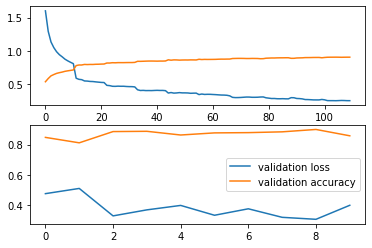

In [50]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

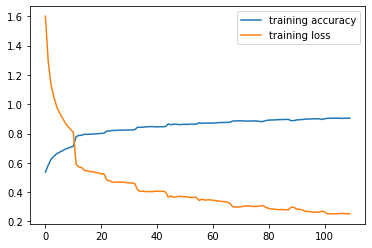

In [51]:
fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
#fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')
#fig2.plot(total_loss_val, label = 'validation loss')
#fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

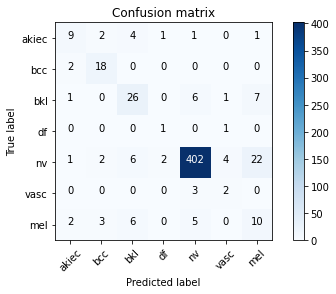

In [53]:
# Validation data evaluation

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

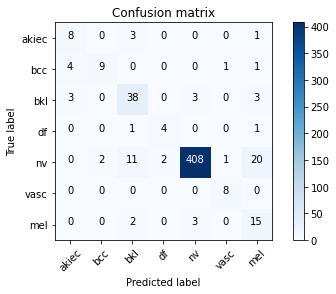

In [56]:
# Test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx_test, plot_labels)

In [57]:
# Generate a validation classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.60      0.50      0.55        18
         bcc       0.72      0.90      0.80        20
         bkl       0.62      0.63      0.63        41
          df       0.25      0.50      0.33         2
          nv       0.96      0.92      0.94       439
        vasc       0.25      0.40      0.31         5
         mel       0.25      0.38      0.30        26

    accuracy                           0.85       551
   macro avg       0.52      0.60      0.55       551
weighted avg       0.87      0.85      0.86       551



In [58]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.53      0.67      0.59        12
         bcc       0.82      0.60      0.69        15
         bkl       0.69      0.81      0.75        47
          df       0.67      0.67      0.67         6
          nv       0.99      0.92      0.95       444
        vasc       0.80      1.00      0.89         8
         mel       0.37      0.75      0.49        20

    accuracy                           0.89       552
   macro avg       0.69      0.77      0.72       552
weighted avg       0.92      0.89      0.90       552



Text(0, 0.5, 'Fraction classified incorrectly')

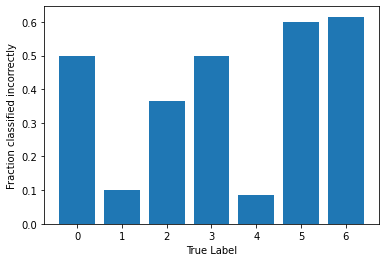

In [59]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Text(0, 0.5, 'Fraction classified incorrectly')

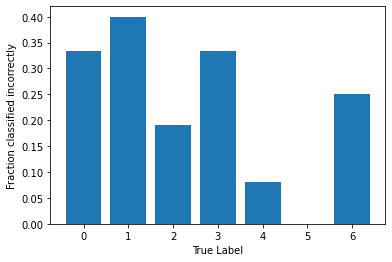

In [60]:
label_frac_error = 1 - np.diag(confusion_mtx_test) / np.sum(confusion_mtx_test, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')